In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [3]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K318', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


subject:  11%|█         | 12/109 [00:00<00:00, 112.41it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  22%|██▏       | 24/109 [00:00<00:02, 33.70it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  28%|██▊       | 30/109 [00:00<00:02, 30.13it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s

loaded 97 subjects - 24972 epochs
CPU times: user 1min 21s, sys: 8.46 s, total: 1min 30s
Wall time: 1min 43s


,subject,scenario,event,label,trial,split,epochs
0,K001,nâng tay trái,Thinking,nâng tay trái,0,train,9
1,K001,nâng tay trái,Resting,rest,0,train,10
2,K001,nâng tay trái,Resting,rest,1,train,5
3,K001,nâng tay trái,Thinking,nâng tay trái,1,train,10
4,K001,nâng tay trái,Resting,rest,2,train,4
...,...,...,...,...,...,...,...
2749,K375,nâng chân phải,Resting,rest,2,train,4
2750,K375,nâng chân phải,Resting,rest,3,train,5
2751,K375,nâng chân phải,Thinking,nâng chân phải,2,train,11
2752,K375,nâng chân phải,Resting,rest,4,train,6


In [4]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'nâng chân phải': 1,
 'nâng chân trái': 2,
 'nâng tay phải': 3,
 'nâng tay trái': 4}

In [5]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

In [10]:
ds_ea = deepcopy(ds)
euclidean_alignment(ds_ea, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 97/97 [00:05<00:00, 16.39it/s]


In [6]:
train_trials = {
    "rest": [0, 1],
    "nâng chân trái": [0],
    "nâng chân phải": [0],
    "nâng tay trái": [0],
    "nâng tay phải": [0],
}

# valid_trials = {
#     "rest": [2, 3],
#     "nâng chân trái": [1],
#     "nâng chân phải": [1],
#     "nâng tay trái": [1],
#     "nâng tay phải": [1],
# }

# test_trials = {
#     "rest": [4, 5],
#     "nâng chân trái": [2],
#     "nâng chân phải": [2],
#     "nâng tay trái": [2],
#     "nâng tay phải": [2],
# }

test_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    'K313', 'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
}

test_subjects = sorted(list(test_subjects))
# test_subjects = ["K313"]

test_acc = list()
test_f1 = list()
for subject in tqdm(test_subjects, desc="subject"):
    print(f"==========subject {subject}==========")
    
    # init data
#     # intra-subject
#     Xtrain = list()
#     Ytrain = list()
#     Xtest = list()
#     Ytest = list()
#     for i, r in ds_info[ds_info["subject"] == subject].iterrows():
#         x = ds.datasets[i].windows.get_data()
#         y = ds.datasets[i].y
#         if r["trial"] in train_trials[r["label"]]:
#             Xtrain.append(x)
#             Ytrain.extend(y)
#         else:
#             Xtest.append(x)
#             Ytest.extend(y)
            
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.array(Ytrain, dtype=int)
#     Xtest = np.concatenate(Xtest, axis=0)
#     Ytest = np.array(Ytest, dtype=int)
    
#     # EA
#     Xtrain = list()
#     Ytrain = list()
#     Xtest = list()
#     Ytest = list()
#     for subj in ds_info["subject"].unique():
#         if subj == "K318":
#             continue
#         if subj not in test_subjects:
#             continue
            
#         Xsub = list()
#         Ysub = list()
#         for i, r in ds_info[ds_info["subject"] == subj].iterrows():
#             x = ds.datasets[i].windows.get_data()
#             y = ds.datasets[i].y
#             # x = ds_ea.datasets[i].windows.get_data()
#             # y = ds_ea.datasets[i].y
#             Xsub.append(x)
#             Ysub.extend(y)
        
#         Xsub = np.concatenate(Xsub, axis=0)
#         Ysub = np.array(Ysub, dtype=int)
        
#         if subj != subject:
#             Xtrain.append(Xsub)
#             Ytrain.append(Ysub)
#         else:
#             Xtest.append(Xsub)
#             Ytest.append(Ysub)
            
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.concatenate(Ytrain, axis=0)
#     Xtest = np.concatenate(Xtest, axis=0)
#     Ytest = np.concatenate(Ytest, axis=0)
    
    # LA
    DXtrain = defaultdict(list)
    DYtrain = defaultdict(list)
    DXtest = defaultdict(list)
    DYtest = defaultdict(list)
    for subj in ds_info["subject"].unique():
        if subj == "K318":
            continue
        if subj not in test_subjects:
            continue
            
        for i, r in ds_info[ds_info["subject"] == subj].iterrows():
            x = ds.datasets[i].windows.get_data()
            y = ds.datasets[i].y
            if subj == subject:
                if r["trial"] in train_trials[r["label"]]:
                    DXtrain[subj].append(x)
                    DYtrain[subj].extend(y)
                else:
                    DXtest[subj].append(x)
                    DYtest[subj].extend(y)
            else:
                DXtrain[subj].append(x)
                DYtrain[subj].extend(y)
                
    for k, v in DXtrain.items():
        DXtrain[k] = np.concatenate(v, axis=0)
    for k, v in DXtest.items():
        DXtest[k] = np.concatenate(v, axis=0)
    for k, v in DYtrain.items():
        DYtrain[k] = np.array(v, dtype=int)
    for k, v in DYtest.items():
        DYtest[k] = np.array(v, dtype=int)
    
    r = np_compute_target_transform_mats(DXtrain[subject], DYtrain[subject])
    for k, v in DXtrain.items():
        if k == subject:
            continue
        DXtrain[k] = np_label_alignment(v, DYtrain[k], r)
        
    Xtrain = list()
    Ytrain = list()
    for k, v in DXtrain.items():
        Xtrain.append(v)
        Ytrain.append(DYtrain[k])
        
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.concatenate(Ytrain, axis=0)
    Xtest = DXtest[subject]
    Ytest = DYtest[subject]
    
    print(np.bincount(Ytrain), np.bincount(Ytest))
    
    # init model
    clf = make_pipeline(
        Covariances("cov"),
        TSclassifier(
            metric="riemann",
            # clf=SVC(
            clf=LinearSVC(
                C=1.0,
                # kernel="rbf",
                tol=1e-7,
                max_iter=30000,
                class_weight="balanced",
                random_state=42,
            ),
            # clf=LinearDiscriminantAnalysis(
            #     solver="lsqr",
            #     shrinkage="auto",
            #     n_components=None,
            #     tol=1e-7,
            #     covariance_estimator=None,
            # ),
        ),
    )
    
    # clf = make_pipeline(
    #     mne.decoding.CSP(
    #         n_components=8,
    #         # reg="ledoit_wolf",
    #         log=True,
    #         norm_trace=False,
    #     ),
    #     # SVC(
    #     LinearSVC(
    #         C=1.0,
    #         # kernel="rbf",
    #         tol=1e-7,
    #         max_iter=30000,
    #         class_weight="balanced",
    #         random_state=42,
    #     ),
    #     # OneVsRestClassifier(LinearSVC(C=1.0, tol=1e-7, max_iter=30000, class_weight='balanced', random_state=42), n_jobs=-1),
    #     # LinearDiscriminantAnalysis(
    #     #     solver="lsqr",
    #     #     shrinkage="auto",
    #     #     n_components=None,
    #     #     tol=1e-7,
    #     #     covariance_estimator=None,
    #     # ),
    # )
    
    # training
    clf.fit(Xtrain, Ytrain)
    
    # evaluate
    Ypred = clf.predict(Xtest)
    
    acc = metrics.balanced_accuracy_score(Ytest, Ypred)
    f1 = metrics.f1_score(Ytest, Ypred, average='weighted')
    test_acc.append(acc)
    test_f1.append(f1)
    print(f"accuracy: {acc}")
    print(f"f1_weighted: {f1}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, Ypred)}")
    
    # break

subject:   0%|          | 0/60 [00:00<?, ?it/s]

==========subject K300==========
[9568 1880 1873 1877 1860] [139  14  20  17  38]


subject:   2%|▏         | 1/60 [02:04<2:02:46, 124.85s/it]

accuracy: 0.4393188854489164
f1_weighted: 0.602159646461717
confusion matrix:
[[139   0   0   0   0]
 [  0  14   0   0   0]
 [  3  17   0   0   0]
 [  4   8   3   2   0]
 [ 35   0   0   0   3]]
==========subject K309==========
[9564 1875 1874 1874 1880] [143  19  19  20  18]


subject:   3%|▎         | 2/60 [04:47<2:22:07, 147.03s/it]

accuracy: 0.7276657260867787
f1_weighted: 0.8696825113078915
confusion matrix:
[[142   1   0   0   0]
 [  0  19   0   0   0]
 [  2   4  13   0   0]
 [  2   0  11   7   0]
 [  1   0   0   6  11]]
==========subject K310==========
[9542 1874 1872 1873 1875] [165  20  21  21  23]


subject:   5%|▌         | 3/60 [06:45<2:07:15, 133.95s/it]

accuracy: 0.2746583850931677
f1_weighted: 0.5967987102949696
confusion matrix:
[[165   0   0   0   0]
 [ 17   2   1   0   0]
 [ 18   0   3   0   0]
 [ 18   0   2   0   1]
 [ 18   0   0   2   3]]
==========subject K311==========
[9555 1870 1874 1868 1875] [152  24  19  26  23]


subject:   7%|▋         | 4/60 [08:59<2:04:49, 133.75s/it]

accuracy: 0.7556694830722291
f1_weighted: 0.8809845029145097
confusion matrix:
[[152   0   0   0   0]
 [  1  23   0   0   0]
 [  5   9   5   0   0]
 [  0   4   0  19   3]
 [  0   0   0   4  19]]
==========subject K312==========
[9545 1864 1871 1870 1861] [162  30  22  24  37]


subject:   8%|▊         | 5/60 [11:03<1:59:26, 130.30s/it]

accuracy: 0.7481798465131798
f1_weighted: 0.8364081464521935
confusion matrix:
[[161   0   0   0   1]
 [  6  19   5   0   0]
 [  0   0  22   0   0]
 [  0   0   7  17   0]
 [ 22   0   0   0  15]]
==========subject K313==========
[9556 1869 1867 1867 1874] [151  25  26  27  24]


subject:  10%|█         | 6/60 [13:08<1:55:42, 128.57s/it]

accuracy: 0.8256470066602516
f1_weighted: 0.8962251154034167
confusion matrix:
[[150   0   1   0   0]
 [  0  24   1   0   0]
 [  2   0  22   2   0]
 [  1   6  10  10   0]
 [  1   0   0   0  23]]
==========subject K314==========
[9572 1874 1874 1875 1873] [135  20  19  19  25]


subject:  12%|█▏        | 7/60 [15:01<1:49:02, 123.44s/it]

accuracy: 0.5026315789473684
f1_weighted: 0.6841658725336219
confusion matrix:
[[135   0   0   0   0]
 [ 15   5   0   0   0]
 [  1   2  16   0   0]
 [  4   0   7   8   0]
 [ 17   0   3   5   0]]
==========subject K315==========
[9538 1867 1867 1871 1873] [169  27  26  23  25]


subject:  13%|█▎        | 8/60 [17:05<1:47:14, 123.74s/it]

accuracy: 0.6166099343490649
f1_weighted: 0.7944594606708306
confusion matrix:
[[169   0   0   0   0]
 [  2  25   0   0   0]
 [  7  16   3   0   0]
 [  3   7   1  12   0]
 [  4   0   0   8  13]]
==========subject K316==========
[9534 1869 1872 1873 1876] [173  25  21  21  22]


subject:  15%|█▌        | 9/60 [18:57<1:41:53, 119.88s/it]

accuracy: 0.5319694717613792
f1_weighted: 0.7556345178884284
confusion matrix:
[[172   0   0   0   1]
 [  1  24   0   0   0]
 [  0  21   0   0   0]
 [ 10   0   0  11   0]
 [  9   0   0   9   4]]
==========subject K319==========
[9535 1874 1875 1873 1883] [172  20  18  21  15]


subject:  17%|█▋        | 10/60 [20:48<1:37:33, 117.08s/it]

accuracy: 0.2
f1_weighted: 0.5895106009883628
confusion matrix:
[[172   0   0   0   0]
 [ 18   0   0   2   0]
 [ 18   0   0   0   0]
 [ 17   0   4   0   0]
 [ 11   0   3   1   0]]
==========subject K320==========
[9598 1874 1878 1877 1881] [109  20  15  17  17]


subject:  18%|█▊        | 11/60 [22:51<1:37:15, 119.10s/it]

accuracy: 0.3768627450980392
f1_weighted: 0.624639319351931
confusion matrix:
[[109   0   0   0   0]
 [  4  10   6   0   0]
 [  7   4   4   0   0]
 [ 17   0   0   0   0]
 [ 15   0   0   0   2]]
==========subject K321==========
[9678 1874 1873 1875 1879] [29 20 20 19 19]


subject:  20%|██        | 12/60 [24:56<1:36:43, 120.90s/it]

accuracy: 0.6794736842105263
f1_weighted: 0.6468805253851984
confusion matrix:
[[29  0  0  0  0]
 [ 6  9  5  0  0]
 [ 9 11  0  0  0]
 [ 1  0  0 18  0]
 [ 0  0  0  0 19]]
==========subject K322==========
[9631 1875 1876 1876 1879] [76 19 17 18 19]


subject:  22%|██▏       | 13/60 [26:42<1:30:59, 116.17s/it]

accuracy: 0.678328173374613
f1_weighted: 0.7712768293225661
confusion matrix:
[[74  0  0  1  1]
 [ 8 11  0  0  0]
 [ 8  1  8  0  0]
 [ 0  0  0 18  0]
 [12  0  0  0  7]]
==========subject K323==========
[9648 1877 1877 1876 1879] [59 17 16 18 19]


subject:  23%|██▎       | 14/60 [28:36<1:28:44, 115.75s/it]

accuracy: 0.827165725047081
f1_weighted: 0.8611333541566101
confusion matrix:
[[58  0  1  0  0]
 [ 0 17  0  0  0]
 [ 0  0 14  2  0]
 [ 0  0  9  5  4]
 [ 0  0  0  0 19]]
==========subject K324==========
[9666 1877 1874 1873 1877] [41 17 19 21 21]


subject:  25%|██▌       | 15/60 [30:15<1:22:51, 110.47s/it]

accuracy: 0.8169814780854574
f1_weighted: 0.8124328418446066
confusion matrix:
[[34  2  0  0  5]
 [ 0 17  0  0  0]
 [ 3  0 13  3  0]
 [ 1  1  4 15  0]
 [ 3  0  0  0 18]]
==========subject K325==========
[9666 1875 1862 1877 1882] [41 19 31 17 16]


subject:  27%|██▋       | 16/60 [32:02<1:20:26, 109.68s/it]

accuracy: 0.7435533806052133
f1_weighted: 0.6607622027309885
confusion matrix:
[[41  0  0  0  0]
 [ 0 18  1  0  0]
 [ 6 22  2  0  1]
 [ 1  3  1 12  0]
 [ 0  0  0  0 16]]
==========subject K326==========
[9666 1871 1870 1871 1875] [41 23 23 23 23]


subject:  28%|██▊       | 17/60 [33:31<1:13:57, 103.21s/it]

accuracy: 0.4608695652173913
f1_weighted: 0.48375552362663
confusion matrix:
[[41  0  0  0  0]
 [13 10  0  0  0]
 [ 6  0  1 14  2]
 [12  0  1  9  1]
 [10  0  0  3 10]]
==========subject K327==========
[9676 1862 1876 1875 1878] [31 32 17 19 20]


subject:  30%|███       | 18/60 [35:10<1:11:32, 102.21s/it]

accuracy: 0.6181075851393188
f1_weighted: 0.6095509097948122
confusion matrix:
[[31  0  0  0  0]
 [ 5  9 14  4  0]
 [ 0  0 10  7  0]
 [ 4  0  7  8  0]
 [ 4  0  0  0 16]]
==========subject K328==========
[9578 1877 1870 1872 1874] [129  17  23  22  24]


subject:  32%|███▏      | 19/60 [36:48<1:08:58, 100.94s/it]

accuracy: 0.6751356273734791
f1_weighted: 0.8247441147348119
confusion matrix:
[[129   0   0   0   0]
 [  5  12   0   0   0]
 [  1  13   8   1   0]
 [  4   3   7   8   0]
 [  1   0   0   0  23]]
==========subject K329==========
[9660 1877 1876 1875 1879] [47 17 17 19 19]


subject:  33%|███▎      | 20/60 [38:19<1:05:11, 97.79s/it] 

accuracy: 0.6055727554179566
f1_weighted: 0.6510673422438127
confusion matrix:
[[47  0  0  0  0]
 [ 3 12  0  2  0]
 [12  3  1  1  0]
 [ 3  0  0 16  0]
 [ 5  0  0  6  8]]
==========subject K330==========
[9665 1875 1874 1877 1881] [42 19 19 17 17]


subject:  35%|███▌      | 21/60 [39:56<1:03:26, 97.60s/it]

accuracy: 0.5419873212442872
f1_weighted: 0.5916143530829054
confusion matrix:
[[41  0  1  0  0]
 [ 1  7 11  0  0]
 [ 1  1 17  0  0]
 [ 9  6  0  2  0]
 [ 7  0  0  4  6]]
==========subject K331==========
[9669 1876 1874 1877 1876] [38 18 19 17 22]


subject:  37%|███▋      | 22/60 [41:34<1:01:54, 97.75s/it]

accuracy: 0.5394220846233231
f1_weighted: 0.5122697622145731
confusion matrix:
[[38  0  0  0  0]
 [ 0 15  3  0  0]
 [ 2 13  3  1  0]
 [ 0  5  0 12  0]
 [ 6  0  0 16  0]]
==========subject K332==========
[9624 1875 1869 1876 1880] [83 19 24 18 18]


subject:  38%|███▊      | 23/60 [43:35<1:04:35, 104.73s/it]

accuracy: 0.7046079053054323
f1_weighted: 0.8035567783684544
confusion matrix:
[[82  0  1  0  0]
 [ 3  7  7  2  0]
 [ 4  0 20  0  0]
 [ 3  0  7  7  1]
 [ 1  0  0  0 17]]
==========subject K333==========
[9687 1874 1875 1876 1880] [20 20 18 18 18]


subject:  40%|████      | 24/60 [45:22<1:03:16, 105.46s/it]

accuracy: 0.5688888888888888
f1_weighted: 0.5014489057042247
confusion matrix:
[[20  0  0  0  0]
 [ 2 18  0  0  0]
 [ 0 11  3  4  0]
 [ 0  3  1 14  0]
 [ 0  0  0 18  0]]
==========subject K334==========
[9690 1864 1870 1869 1870] [17 30 23 25 28]


subject:  42%|████▏     | 25/60 [46:59<59:58, 102.81s/it]  

accuracy: 0.3173623188405797
f1_weighted: 0.25396581905103
confusion matrix:
[[17  0  0  0  0]
 [15  4 11  0  0]
 [22  0  1  0  0]
 [11  3  7  4  0]
 [18  1  2  0  7]]
==========subject K335==========
[9698 1870 1869 1873 1876] [ 9 24 24 21 22]


subject:  43%|████▎     | 26/60 [48:40<57:56, 102.24s/it]

accuracy: 0.7099567099567099
f1_weighted: 0.6419291754756871
confusion matrix:
[[ 9  0  0  0  0]
 [ 2 22  0  0  0]
 [ 3 13  6  2  0]
 [ 1  5  6  9  0]
 [ 0  0  0  1 21]]
==========subject K336==========
[9685 1868 1871 1869 1875] [22 26 22 25 23]


subject:  45%|████▌     | 27/60 [50:19<55:39, 101.20s/it]

accuracy: 0.7976102158710854
f1_weighted: 0.7956148170355362
confusion matrix:
[[22  0  0  0  0]
 [ 0 22  2  2  0]
 [ 0  1 19  2  0]
 [ 1  0  3 20  1]
 [ 0  0  0 12 11]]
==========subject K337==========
[9650 1871 1869 1870 1874] [57 23 24 24 24]


subject:  47%|████▋     | 28/60 [52:41<1:00:32, 113.53s/it]

accuracy: 0.8083333333333332
f1_weighted: 0.8407542593046209
confusion matrix:
[[57  0  0  0  0]
 [ 0 23  0  0  0]
 [ 0 14 10  0  0]
 [ 3  2  3 16  0]
 [ 1  0  0  0 23]]
==========subject K338==========
[9458 1870 1854 1868 1875] [249  24  39  26  23]


subject:  48%|████▊     | 29/60 [54:55<1:01:51, 119.74s/it]

accuracy: 0.6234392419175029
f1_weighted: 0.8041442453246834
confusion matrix:
[[249   0   0   0   0]
 [  0  23   1   0   0]
 [ 18  12   9   0   0]
 [  3   0   0  23   0]
 [  2   0   0  20   1]]
==========subject K339==========
[9501 1872 1871 1869 1876] [206  22  22  25  22]


subject:  50%|█████     | 30/60 [57:10<1:02:05, 124.17s/it]

accuracy: 0.641694616063548
f1_weighted: 0.8469235814210868
confusion matrix:
[[204   0   0   0   2]
 [  2  15   5   0   0]
 [  6   5  10   1   0]
 [  6   0   9  10   0]
 [  3   0   0   4  15]]
==========subject K340==========
[9526 1868 1867 1870 1874] [181  26  26  24  24]


subject:  52%|█████▏    | 31/60 [59:11<59:39, 123.45s/it]  

accuracy: 0.33076923076923076
f1_weighted: 0.6405603614818823
confusion matrix:
[[181   0   0   0   0]
 [ 16   4   6   0   0]
 [ 13  13   0   0   0]
 [  8   7   7   0   2]
 [  8   4   0   0  12]]
==========subject K342==========
[9515 1876 1876 1877 1881] [192  18  17  17  17]


subject:  53%|█████▎    | 32/60 [1:01:10<56:59, 122.12s/it]

accuracy: 0.3492851307189543
f1_weighted: 0.7277045023752934
confusion matrix:
[[191   0   0   0   1]
 [  8   4   4   2   0]
 [ 11   4   1   1   0]
 [  6   4   0   7   0]
 [ 16   0   0   0   1]]
==========subject K343==========
[9536 1879 1877 1878 1882] [171  15  16  16  16]


subject:  55%|█████▌    | 33/60 [1:03:09<54:25, 120.93s/it]

accuracy: 0.4683333333333334
f1_weighted: 0.80267258382643
confusion matrix:
[[171   0   0   0   0]
 [  4   7   0   4   0]
 [  0  15   0   1   0]
 [  1   3   3   7   2]
 [  4   0   1   4   7]]
==========subject K344==========
[9532 1877 1875 1875 1882] [175  17  18  19  16]


subject:  57%|█████▋    | 34/60 [1:05:10<52:25, 120.99s/it]

accuracy: 0.2443517126148705
f1_weighted: 0.6295739434943703
confusion matrix:
[[173   0   0   2   0]
 [ 17   0   0   0   0]
 [ 17   0   1   0   0]
 [ 16   0   2   1   0]
 [ 13   0   0   1   2]]
==========subject K350==========
[9671 1868 1874 1867 1877] [36 26 19 27 21]


subject:  58%|█████▊    | 35/60 [1:07:46<54:51, 131.65s/it]

accuracy: 0.4188098451256346
f1_weighted: 0.42624395415093086
confusion matrix:
[[34  0  0  2  0]
 [ 1  2  7 16  0]
 [ 0  2  5 12  0]
 [12  9  5  0  1]
 [ 2  1  0  1 17]]
==========subject K351==========
[9692 1873 1869 1873 1873] [15 21 24 21 25]


subject:  60%|██████    | 36/60 [1:09:52<51:59, 129.98s/it]

accuracy: 0.6598571428571429
f1_weighted: 0.6073846763263434
confusion matrix:
[[15  0  0  0  0]
 [ 1 18  2  0  0]
 [ 5  9  7  3  0]
 [ 0  5 12  4  0]
 [ 1  0  0  0 24]]
==========subject K352==========
[9701 1864 1868 1871 1868] [ 6 30 25 23 30]


subject:  62%|██████▏   | 37/60 [1:12:06<50:17, 131.20s/it]

accuracy: 0.5121159420289855
f1_weighted: 0.40025413183307923
confusion matrix:
[[ 6  0  0  0  0]
 [ 3 26  0  0  1]
 [ 2 11  8  3  1]
 [ 3  6  3  4  7]
 [ 6  4  4 10  6]]
==========subject K353==========
[9700 1872 1871 1870 1879] [ 7 22 22 24 19]


subject:  63%|██████▎   | 38/60 [1:14:08<47:03, 128.33s/it]

accuracy: 0.5548245614035088
f1_weighted: 0.5104419160802139
confusion matrix:
[[ 7  0  0  0  0]
 [ 1 13  8  0  0]
 [ 5  7  9  1  0]
 [ 5  0  8 11  0]
 [11  0  1  1  6]]
==========subject K354==========
[9692 1876 1874 1870 1877] [15 18 19 24 21]


subject:  65%|██████▌   | 39/60 [1:16:10<44:16, 126.52s/it]

accuracy: 0.6054302422723475
f1_weighted: 0.4929559911463838
confusion matrix:
[[15  0  0  0  0]
 [ 1 17  0  0  0]
 [ 3  7  7  2  0]
 [ 4  5 15  0  0]
 [ 2  0  3  1 15]]
==========subject K355==========
[9565 1875 1876 1873 1881] [142  19  17  21  17]


subject:  67%|██████▋   | 40/60 [1:17:39<38:23, 115.18s/it]

accuracy: 0.502940657360053
f1_weighted: 0.7447100246290062
confusion matrix:
[[141   0   0   1   0]
 [  6  13   0   0   0]
 [ 11   0   6   0   0]
 [ 16   0   1   4   0]
 [  8   0   0   4   5]]
==========subject K356==========
[9691 1876 1873 1874 1877] [16 18 20 20 21]


subject:  68%|██████▊   | 41/60 [1:19:13<34:25, 108.73s/it]

accuracy: 0.48809523809523814
f1_weighted: 0.44732621471865336
confusion matrix:
[[16  0  0  0  0]
 [ 0  9  7  2  0]
 [ 1  5  9  1  4]
 [ 1 11  0  6  2]
 [ 1  1  3 12  4]]
==========subject K357==========
[9582 1875 1874 1876 1880] [125  19  19  18  18]


subject:  70%|███████   | 42/60 [1:20:51<31:42, 105.67s/it]

accuracy: 0.3655298245614035
f1_weighted: 0.6497009587280677
confusion matrix:
[[121   0   2   2   0]
 [  8   9   2   0   0]
 [  8   5   1   5   0]
 [  6   1   7   4   0]
 [  5   0   0  11   2]]
==========subject K358==========
[9582 1878 1875 1875 1879] [125  16  18  19  19]


subject:  72%|███████▏  | 43/60 [1:22:29<29:16, 103.32s/it]

accuracy: 0.717690058479532
f1_weighted: 0.8497604958171747
confusion matrix:
[[125   0   0   0   0]
 [  2  14   0   0   0]
 [  0   8  10   0   0]
 [  3   4   0   4   8]
 [  1   0   0   0  18]]
==========subject K359==========
[9580 1877 1876 1875 1878] [127  17  17  19  20]


subject:  73%|███████▎  | 44/60 [1:24:29<28:54, 108.38s/it]

accuracy: 0.7091331269349845
f1_weighted: 0.8670617007513559
confusion matrix:
[[127   0   0   0   0]
 [  2  11   4   0   0]
 [  3   7   7   0   0]
 [  1   0   4  14   0]
 [  1   0   1   3  15]]
==========subject K360==========
[9571 1871 1866 1870 1875] [136  23  27  24  23]


subject:  75%|███████▌  | 45/60 [1:26:17<27:01, 108.09s/it]

accuracy: 0.7280998389694041
f1_weighted: 0.847053467494409
confusion matrix:
[[136   0   0   0   0]
 [  8  11   0   4   0]
 [  1   0  26   0   0]
 [  5   0   6  10   3]
 [  4   0   0   1  18]]
==========subject K361==========
[9599 1871 1868 1873 1877] [108  23  25  21  21]


subject:  77%|███████▋  | 46/60 [1:27:46<23:53, 102.37s/it]

accuracy: 0.7203975155279503
f1_weighted: 0.8371896753404746
confusion matrix:
[[108   0   0   0   0]
 [  3  17   3   0   0]
 [  4   3  18   0   0]
 [  0   4   3  14   0]
 [  1   0   0  10  10]]
==========subject K362==========
[9574 1873 1867 1869 1875] [133  21  26  25  23]


subject:  78%|███████▊  | 47/60 [1:29:27<22:05, 101.99s/it]

accuracy: 0.5929600254817646
f1_weighted: 0.7368201226973157
confusion matrix:
[[133   0   0   0   0]
 [  8  13   0   0   0]
 [ 13   6   7   0   0]
 [  9  10   3   3   0]
 [  1   0   0   0  22]]
==========subject K363==========
[9694 1877 1875 1873 1878] [13 17 18 21 20]


subject:  80%|████████  | 48/60 [1:31:08<20:20, 101.70s/it]

accuracy: 0.3495238095238095
f1_weighted: 0.2001932327238011
confusion matrix:
[[13  0  0  0  0]
 [12  0  0  5  0]
 [14  0  0  0  4]
 [ 6  0  1  1 13]
 [ 6  0  0  0 14]]
==========subject K364==========
[9563 1873 1865 1871 1874] [144  21  28  23  24]


subject:  82%|████████▏ | 49/60 [1:32:33<17:43, 96.69s/it] 

accuracy: 0.46413906142167016
f1_weighted: 0.6876083589975721
confusion matrix:
[[143   0   0   1   0]
 [  8   9   0   4   0]
 [  4  11  13   0   0]
 [  3   0  10  10   0]
 [  7   2   0  15   0]]
==========subject K365==========
[9704 1877 1876 1876 1881] [ 3 17 17 18 17]


subject:  83%|████████▎ | 50/60 [1:34:01<15:40, 94.02s/it]

accuracy: 0.4901960784313726
f1_weighted: 0.41632877837514937
confusion matrix:
[[ 3  0  0  0  0]
 [13  3  1  0  0]
 [ 3 12  2  0  0]
 [ 8  0  4  6  0]
 [ 0  0  0  3 14]]
==========subject K366==========
[9563 1871 1873 1874 1872] [144  23  20  20  26]


subject:  85%|████████▌ | 51/60 [1:35:44<14:32, 96.92s/it]

accuracy: 0.8036120401337792
f1_weighted: 0.8974700605152887
confusion matrix:
[[144   0   0   0   0]
 [  1  22   0   0   0]
 [  0   6  14   0   0]
 [  0   2   0  18   0]
 [  1   0   0  13  12]]
==========subject K367==========
[9704 1878 1878 1878 1877] [ 3 16 15 16 21]


subject:  87%|████████▋ | 52/60 [1:37:19<12:50, 96.35s/it]

accuracy: 0.6108333333333333
f1_weighted: 0.516321458160729
confusion matrix:
[[ 3  0  0  0  0]
 [ 1 14  1  0  0]
 [ 0  5  8  2  0]
 [ 6  5  0  5  0]
 [ 4  0  8  2  7]]
==========subject K368==========
[9584 1873 1867 1871 1871] [123  21  26  23  27]


subject:  88%|████████▊ | 53/60 [1:38:54<11:10, 95.79s/it]

accuracy: 0.717985878855444
f1_weighted: 0.8345129561008477
confusion matrix:
[[123   0   0   0   0]
 [  6  14   0   1   0]
 [  1   2  23   0   0]
 [ 16   0   0   6   1]
 [  0   0   0   6  21]]
==========subject K369==========
[9595 1873 1873 1873 1878] [112  21  20  21  20]


subject:  90%|█████████ | 54/60 [1:40:20<09:17, 92.98s/it]

accuracy: 0.6585714285714286
f1_weighted: 0.7990709329941044
confusion matrix:
[[112   0   0   0   0]
 [  5  16   0   0   0]
 [  3   6   7   4   0]
 [  9   0   4   8   0]
 [  4   0   0   0  16]]
==========subject K370==========
[9573 1870 1871 1874 1878] [134  24  22  20  20]


subject:  92%|█████████▏| 55/60 [1:41:40<07:24, 88.89s/it]

accuracy: 0.646386250565355
f1_weighted: 0.8055340747448829
confusion matrix:
[[133   0   0   1   0]
 [  2  16   6   0   0]
 [  9   7   6   0   0]
 [  7   0   0  13   0]
 [  5   0   0   2  13]]
==========subject K371==========
[9596 1870 1869 1869 1877] [111  24  24  25  21]


subject:  93%|█████████▎| 56/60 [1:43:06<05:52, 88.15s/it]

accuracy: 0.5340630630630631
f1_weighted: 0.6840452591529018
confusion matrix:
[[109   0   0   2   0]
 [  1  18   5   0   0]
 [  3   8  11   2   0]
 [ 12   1   0  12   0]
 [  9   0   0  12   0]]
==========subject K372==========
[9600 1872 1872 1874 1877] [107  22  21  20  21]


subject:  95%|█████████▌| 57/60 [1:44:33<04:23, 87.83s/it]

accuracy: 0.7622510822510823
f1_weighted: 0.8577040962091184
confusion matrix:
[[107   0   0   0   0]
 [  1  19   1   1   0]
 [  1  10   7   3   0]
 [  0   0   2  18   0]
 [  4   0   0   2  15]]
==========subject K373==========
[9595 1872 1869 1876 1879] [112  22  24  18  19]


subject:  97%|█████████▋| 58/60 [1:46:14<03:03, 91.80s/it]

accuracy: 0.7252525252525253
f1_weighted: 0.8447991368906902
confusion matrix:
[[112   0   0   0   0]
 [  2  15   0   5   0]
 [  1   9  12   2   0]
 [  0   0   8   8   2]
 [  0   0   0   0  19]]
==========subject K374==========
[9588 1871 1872 1872 1878] [119  23  21  22  20]


subject:  98%|█████████▊| 59/60 [1:47:34<01:28, 88.28s/it]

accuracy: 0.5694429866808383
f1_weighted: 0.752395159216722
confusion matrix:
[[118   1   0   0   0]
 [  4   8   8   3   0]
 [  8   0  12   1   0]
 [  2   4   2  14   0]
 [  1   0   0  13   6]]
==========subject K375==========
[9623 1873 1872 1872 1874] [84 21 21 22 24]


subject: 100%|██████████| 60/60 [1:49:18<00:00, 109.31s/it]

accuracy: 0.656060606060606
f1_weighted: 0.735360673470201
confusion matrix:
[[84  0  0  0  0]
 [ 5 16  0  0  0]
 [ 9  0 12  0  0]
 [ 3  0  0 19  0]
 [ 1  0  0 21  2]]


In [14]:
# intra-subject CSP-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.55556036934984
avg f1: 0.6526765891154205


<AxesSubplot:xlabel='subject'>

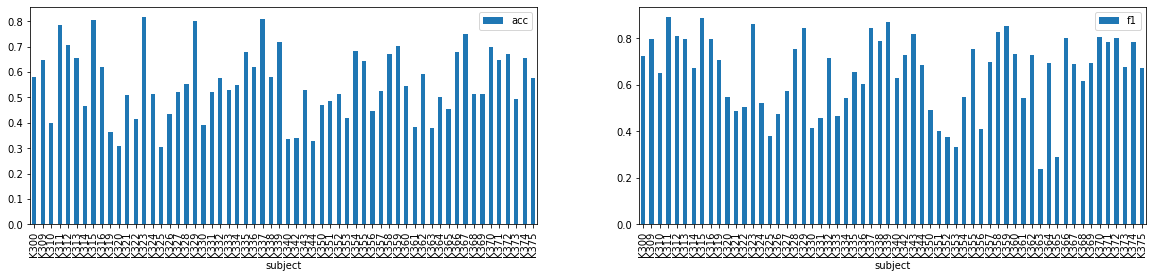

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [18]:
# intra-subject Cov-TangentSpace-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.623936318706582
avg f1: 0.7149484570665078


<AxesSubplot:xlabel='subject'>

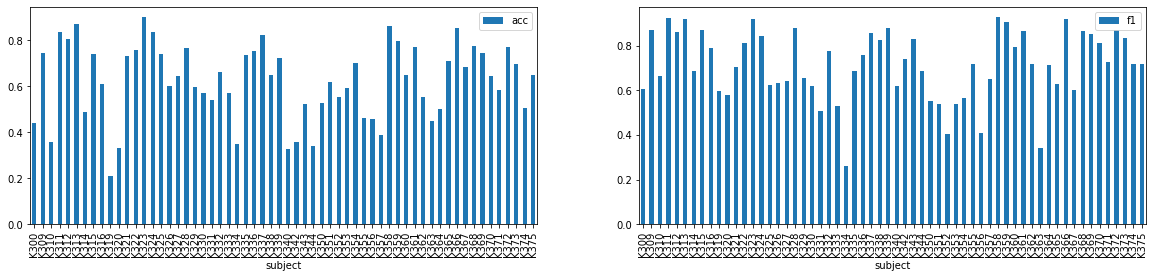

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [7]:
# LOSO - LA-Cov-TangentSpace-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.5885774207370792
avg f1: 0.6882208773922353


<AxesSubplot:xlabel='subject'>

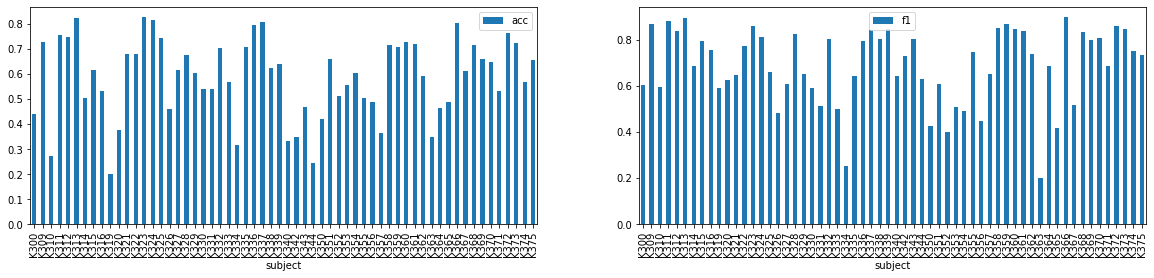

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [10]:
result.sort_values("acc", ascending=False).reset_index(drop=True)

,subject,acc,f1
0,K323,0.827166,0.861133
1,K313,0.825647,0.896225
2,K324,0.816981,0.812433
3,K337,0.808333,0.840754
4,K366,0.803612,0.897470
5,K336,0.797610,0.795615
6,K372,0.762251,0.857704
7,K311,0.755669,0.880985
8,K312,0.748180,0.836408
9,K325,0.743553,0.660762


In [13]:
list(result.sort_values("acc", ascending=False).reset_index(drop=True)[:50]["subject"])

['K323',
 'K313',
 'K324',
 'K337',
 'K366',
 'K336',
 'K372',
 'K311',
 'K312',
 'K325',
 'K360',
 'K309',
 'K373',
 'K361',
 'K368',
 'K358',
 'K335',
 'K359',
 'K332',
 'K321',
 'K322',
 'K328',
 'K351',
 'K369',
 'K375',
 'K370',
 'K339',
 'K338',
 'K327',
 'K315',
 'K367',
 'K329',
 'K354',
 'K362',
 'K374',
 'K333',
 'K353',
 'K330',
 'K331',
 'K371',
 'K316',
 'K352',
 'K355',
 'K314',
 'K365',
 'K356',
 'K343',
 'K364',
 'K326',
 'K300']